### Тема 12. Численное решение жестких систем ОДУ с использованием неявных методов Рунге-Кутты. 

Хромов П.А. М80-304Б-17

Расмотрим систему линейных обыкновенных дифференциальных уравнений (заданную в матрично-векторном виде):

$$ \frac{d\mathbf{u}}{dt} = \mathbf{Au} $$

Предположим, матрица системы $\mathbf{A}$ диагонализируема, т.е. может быть представлена в виде: $\mathbf{\Lambda} = \mathbf{Q^{-1}AQ} $, где матрица $\mathbf{\Lambda}$ - диагональная и составлена из собственных значений матрицы $\mathbf{A}$. Тогда, используя замену переменных $\mathbf{u} = \mathbf{Qw}$ мы приходим к системе:

$$ \frac{d\mathbf{w}}{dt} = \mathbf{\Lambda w} $$

Такая система называется $\textbf{жёсткой}$ если выполняется следующее условие:

$$s = \frac{\max_{k}|Re\lambda_{k}|}{\min_{k}|Re\lambda_{k}} \gg 1$$

где s называется коэффициентом жёсткости. 

"Жёсткость" - нестрогий термин, нет строго обозначенной и универсальной для различных численных методов "границы жёсткости" для s. 

Если матрица $\mathbf{A}$ зависит от $t$, то и коэффициент жёсткости $s(t)$ будет зависеть от t.

Для жёстких систем неявные методы решения ОДУ работают гораздо лучше и стабильнее явных. 

Рассмотрим это на примере простой модели - системы двух ОДУ первого порядка, заданных в векторно-матричном виде.

$$
\frac{d \mathbf{u} }{d t} = A \mathbf{u}
$$

Возьмём значение матрицы следующим:

$$
A = \begin{bmatrix} -10 & 10 \\ 32 & -499 \end{bmatrix}
$$

и зададим начальное условие задачи Коши: $\mathbf{u} = (1, 0)^T$.



In [8]:
import numpy as np 
import matplotlib.pyplot as plt

u_in = np.array([1, 0])
A = np.array([-10, 10, 32, -499])
A = A.reshape(2,2)

Найдём собственные значения матрицы $\mathbf{A}$ используя QR-разложение и наработки из лабораторной работы 1.5:

In [9]:
def householder(vec): 
    #функция считает преобразование Хаусхолдера для заданного вектора и возвращает его матрицу H и итоговый вектор
    
    vec = np.asarray(vec, dtype = float)
    if vec.ndim != 1:
        raise ValueError("vec.ndim = %s, expected 1" % vec.ndim)
    m = vec.shape[0]
    vec = vec.reshape((m, 1))
    if m == 1:
        e = np.asarray([1])
        e = e.reshape((e.shape[0], 1))
        return np.asarray(vec), e
    xlen = length(vec)
    y = np.zeros(vec.shape, dtype = float)
    y[0] = xlen
    
    numerator = 0 # Так лучше считать разность между векторами чтобы избежать ошибки при округлении
    for xi in vec[1:]:
        numerator -= (xi**2)
    denominator = vec[0] + xlen
    diff_x1_y = numerator/denominator
    diff_rest = vec[1:]
    diff = np.insert(diff_rest, 0, diff_x1_y)
    difflen = length(diff)
    
    u = np.divide(diff, difflen)
    u = u.reshape(m, 1)
    ut = np.transpose(u)
    one = np.eye(m, dtype = float)
    H = one - np.dot(2,(np.dot(u, ut)))
    #print(H)
    Hx = np.dot(H, vec)
    #print(Hx)
    return Hx, H # можно было бы вернуть и y, которому равен Hx
    
def length(vec): #2-норма вектора
    xlen = 0 
    for xi in vec:
        xlen += (xi**2)
    xlen = np.sqrt(xlen)
    return xlen

In [10]:
def qr_decomp(a):
    a1 = np.array(a, copy=True, dtype=float)
    m, n = a1.shape
    dim = max(n, m)
    Q = np.eye(dim)
    for i in range(n):
        col = a1[i:, i]
        Hcol, H = householder(col)
        matr = np.eye(dim) #заполняем пустые места единичными подматрицами
        matr[i:, i:] = H[:,:] #это нужно так как каждая следующая матрица H меньше предыдущей
        a1 = matr @ a1 
        Q = Q @ matr
    return Q, a1

In [11]:
def eigenvalues(A, eps):
    maxiter = 1/eps
    N = A.shape[0]
    B = A.copy()
    evalues = np.full((N,), np.inf, dtype = complex)
    roots = []
    for i in range(N-1):
        roots.append([np.inf, np.inf])
    it = 0
    while(np.inf in evalues):
        B_prev = B
        Q, R = qr_decomp(B)
        B = R @ Q
        sum_col = 0
        roots_prev = roots.copy()
        for j in range(N-1):
            coefs = []
            coefs.append(1)
            coefs.append(B[j+1, j+1] - B[j, j])
            coefs.append(B[j, j]*B[j+1, j+1] - B[j, j+1]*B[j+1, j])
            roots[j] = np.roots(coefs)
        for j in range(N):
            for i in range(j+1, N):
                sum_col += B[i, j] ** 2
            sum_col = np.sqrt(sum_col)
            #print("Сумма колонки " +str(j+1) + ": " + str(sum_col))
            if sum_col <= eps:
                evalues[j] = B[j, j]
            elif(it > maxiter and j < N-1 and sum_col > eps):
                for i in range(N-1):
                    #print("R: " + str(roots[j][i]) + " R_prev: " + str(roots_prev[j][i]))
                    if np.absolute(roots[j][i] - roots_prev[j][i]) <= eps:
                        evalues[j] = roots[j][0]
                        evalues[j+1] = roots[j][1]
        it += 1
        #print(evalues)
    return evalues

Рассчитаем коэффициент жёсткости

In [12]:
evs = eigenvalues(A, 1e-2)
s_ratio = np.max(np.abs(evs))/np.min(np.abs(evs))
print("Коэффициент жёсткости равен " + str(s_ratio) + ", следовательно, эту систему можно назвать жёсткой. ")

Коэффициент жёсткости равен 53.45902877479386, следовательно, эту систему можно назвать жёсткой. 


Запишем условие абсолютной устойчивости метода Эйлера на примере одного линейного уравнения (наша система состоит из двух таких): 

Уравнение: 
$$\frac{du}{dt} = \lambda u $$

Схема Эйлера:
$$ \frac{y_{n+1} - y_{n}}{dt} = \lambda y_{n} $$

Условие её устойчивости: $$ 0 < dt < \frac{2}{|\lambda |} $$

Попробуем решить эту задачу используя явный метод Эйлера (который является условно устойчивым методом) с большим шагом $t = 0.01$. 

In [13]:
def euler_sys_solve(A, u0, T, dt):
    steps = int(T/dt)
    tt = np.arange(steps+1)*dt
    y = np.empty((steps+1, 2))
    y[0] = u0
    matr = np.linalg.inv(np.eye(A.shape[0]) + A*dt)
    for k in range(steps):
        y[k+1] = np.linalg.solve(matr, y[k])

    return tt, y

Wall time: 74.7 ms


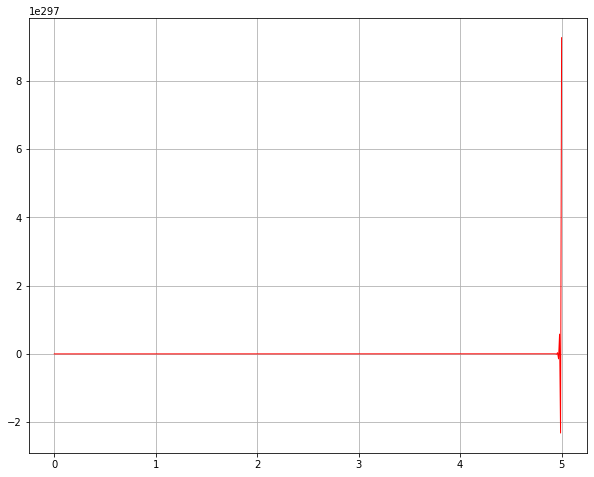

In [14]:
%%time
dt = 0.01
T = 5

tt1, y1 = euler_sys_solve(A, u_in, T, dt)

fig, ax = plt.subplots(figsize = [10, 8])
ax.plot(tt1, y1[:, 0], 'r-', lw=1)
#plt.legend(loc='best')
plt.grid(True)

Это решение неадекватно. Если использовать метод Эйлера с меньшим шагом, например, $t = 0.001$, мы получим решение, гораздо более близкое к истине.

Wall time: 171 ms


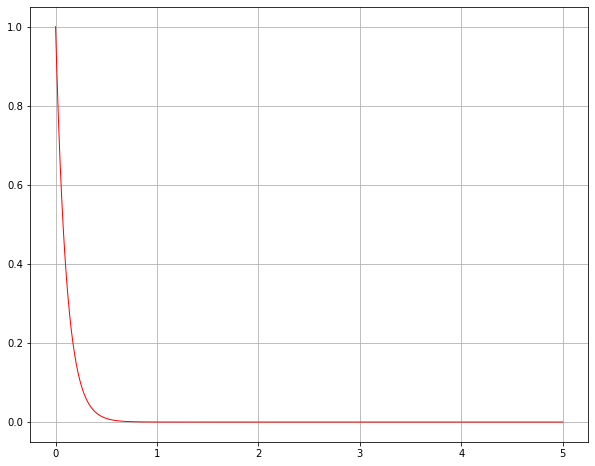

In [15]:
%%time

dt = 0.001

tt2, y2 = euler_sys_solve(A, u_in, T, dt)

fig, ax = plt.subplots(figsize = [10, 8])
ax.plot(tt2, y2[:, 0], 'r-', lw=1)
#plt.legend(loc='best')
plt.grid(True)

Это - иллюстрация того, что явные методы являются условно устойчивыми. Теперь попробуем применить неявный абсолютно устойчивый метод Рунге-Кутты 2-го порядка (модифицированный метод Эйлера с пересчётом). Формулы для расчёта следующие:

Прогноз:
$$ \widetilde{y}_{n+1} = y_{n} + hf(x_{n}, y_{n}) $$

Коррекция: 
$$ y_{n+1} = y_{n} + h\frac{f(x_{n}, y_{n}) + f(x_{n+1}, \widetilde{y}_{n+1})}{2} $$ 

In [16]:
def RK_impl_solve(A, u0, T, dt):
    steps = int(T/dt)
    tt = np.arange(steps+1)*dt
    y = np.empty((steps+1, 2))
    y[0] = u0
    matr = np.eye(A.shape[0]) + A*dt
    for k in range(steps):
        y_temp = np.linalg.solve(matr, y[k]) #прогноз
        sol_temp1 = np.linalg.solve(np.eye(A.shape[0]) + A*(dt/2), y[k])
        sol_temp2 = np.linalg.solve(A, y_temp)
        y[k+1] = sol_temp1 + sol_temp2
        
    return tt, y
        

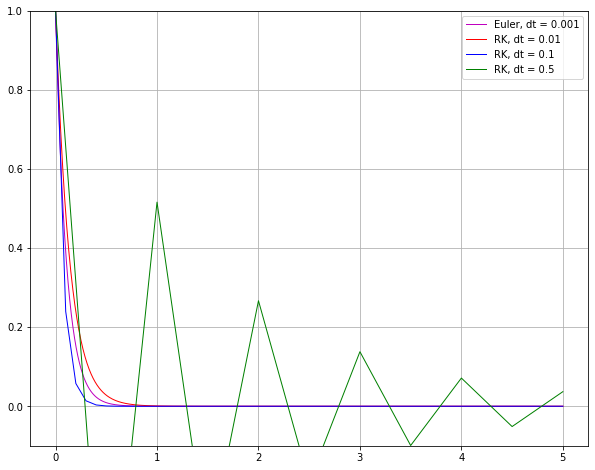

In [17]:
fig, ax = plt.subplots(figsize = [10, 8])
tt3, y3 = RK_impl_solve(A, u_in, T, 0.01)
tt4, y4 = RK_impl_solve(A, u_in, T, 0.1)
tt5, y5 = RK_impl_solve(A, u_in, T, 0.5)
ax.plot(tt2, y2[:, 0], 'm-', lw=1, label = 'Euler, dt = 0.001')
ax.plot(tt3, y3[:, 0], 'r-', lw=1, label='RK, dt = 0.01')
ax.plot(tt4, y4[:, 0], 'b-', lw=1, label='RK, dt = 0.1')
ax.plot(tt5, y5[:, 0], 'g-', lw=1, label='RK, dt = 0.5')
#plt.axhline(0, color='black')
#plt.axvline(0, color='black')
plt.ylim([-0.1, 1.0])

plt.legend(loc='best')
plt.grid(True)


Как видно из графика, мы вполне можем использовать для решения неявным методом Рунге-Кутты гораздо больший шаг, чем для решения условно устойчивыми методами.

Перейдём от рассмотрения жёсткой системы ОДУ с постоянными коэффициентами к рассмотрению  жёсткой задачи Коши:

$$y'(t) = -25y(t) +\cos{t} + 25\sin{t} \\ y(0) = 1 $$

Решением этой задачи является функция: 
$$y(t) = \sin{t} + e^{-25t}$$

In [18]:
func = lambda t, y: -25*y + np.cos(t) + 25*np.sin(t)
y0 = 1

true_sol = lambda t: np.sin(t) + np.exp(-25*t)

Построим график истинного решения задачи:

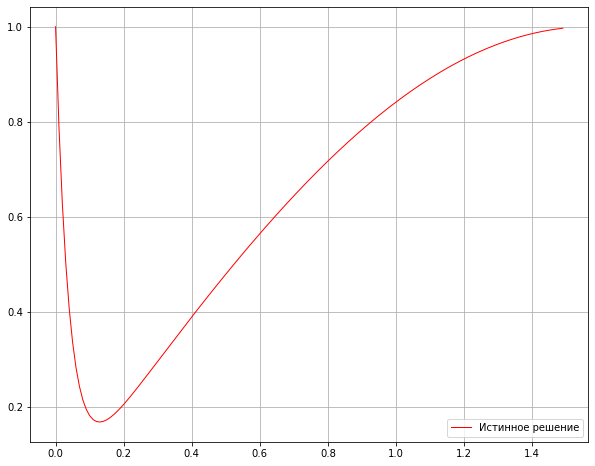

In [42]:
t_arr = np.arange(0, 1.5, 0.01)
true_arr = [true_sol(ti) for ti in t_arr]

fig, ax = plt.subplots(figsize = [10, 8])
ax.plot(t_arr, true_arr, 'r-', lw=1, label = 'Истинное решение')
plt.legend(loc='best')
plt.grid(True)

Как нетрудно видеть, на начальном участке (примерно от $t = 0$ до $t = 0.2$) решение очень быстро меняется. Естественно, на этом участке приближенное решение следует вычислять, используя достаточно маленький шаг. Однако, при $ t > 0.2$ переходная часть решения $e^{-25t}$ почти исчезает и решение начинает изменяться медленно. Возникает соблазн перейти к вычислению со сравнительно крупным шагом.

Решим задачу явным методом Эйлера на отрезке $ t \in [0, 0.25]$ с шагом $ h = 0.01 $ и на отрезке $t \in [0.25, 1.5]$ с шагом $ h = 0.1 $

In [20]:
def euler_cauchy_1(func, y0, a, b): 
    h = 0.01
    lim = 0.25
    num_steps = int((lim-a)/h)
    tt = np.arange(a, lim, h) #отрезок t от 0 до 0.25
    y = np.empty(num_steps+1)
    y[0] = y0
    for k in range(num_steps):
        #print(tt[k])
        y[k+1] = y[k] + h*func(tt[k], y[k])
        
    h = 0.1
    steps = int((b-lim)/h)
    ttn = np.arange(lim, b+h, h) #отрезок t от 0.25 до 1.5
    #print('ns', ttn)
    yn = np.empty(steps+1)
    for i in range(steps):
        #print(ttn[i])
        yn[i+1] = yn[i] + h*func(ttn[i], yn[i])
       
    yf = np.append(y, yn)
    ttf = np.append(tt, ttn)    
    return ttf, yf

Wall time: 45.6 ms


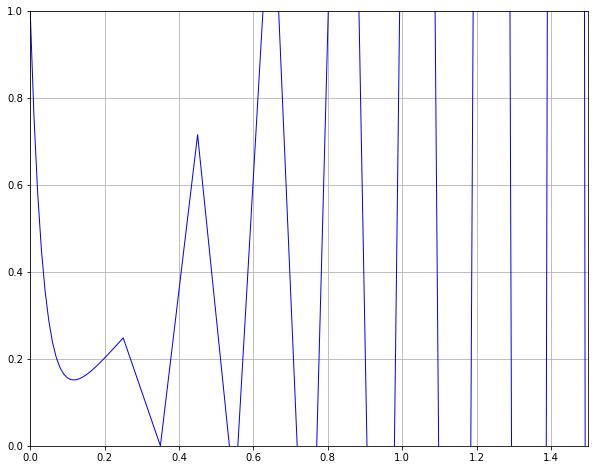

In [21]:
%%time

a = 0; b = 1.5

t_arr1, y_arr1 = euler_cauchy_1(func, y0, a, b)
#y_arr1 = y_arr1[0:-1]
fig, ax = plt.subplots(figsize = [10, 8])
ax.plot(t_arr1, y_arr1, 'b-', lw=1)
plt.xlim([0, 1.5])
plt.ylim([0, 1])
#plt.legend(loc='best')
plt.grid(True)


"Зона жёсткости" начинается почти сразу после 0.25 и жёсткость только увеличивается с ростом t. На этом примере мы снова убеждаемся в том, что условие абсолютной устойчивости метода нарушать нельзя. 

Теперь попробуем сделать то же самое с помощью неявного метода Рунге-Кутты. Решим с его помощью задачу на отрезке $ t \in [0, 0.25]$ с шагом $ h = 0.01 $ и на отрезке $t \in [0.25, 1.5]$ с шагом $ h = 0.1 $


In [45]:
def RK_cauchy2(func, y0, a, b):
    h = 0.01
    lim = 0.25
    num_steps = int((lim-a)/h)
    tt = np.arange(a, lim+h, h) #отрезок t от 0 до 0.25
    y = np.empty(num_steps+1)
    y[0] = y0
    for k in range(num_steps-1):
        #print(tt[k])
        ytemp = y[k] + h*func(tt[k], y[k])
        y[k+1] = y[k] + 0.5*h*(func(tt[k], y[k]) + func(tt[k+1], ytemp))
         
    h = 0.01
    steps = int((b-lim)/h)
    ttn = np.arange(lim, b+h, h)
    #print('ns', ttn)
    yn = np.empty(steps+1)
    for i in range(steps-2):
        #print(ttn[i])
        ytemp = yn[i] + h*func(ttn[i], yn[i])
        yn[i+1] = yn[i] + 0.5*h*(func(ttn[i], yn[i]) + func(ttn[i+1], ytemp))
       
    yf = np.append(y, yn)
    ttf = np.append(tt, ttn)    
    return ttf, yf

Wall time: 42.6 ms


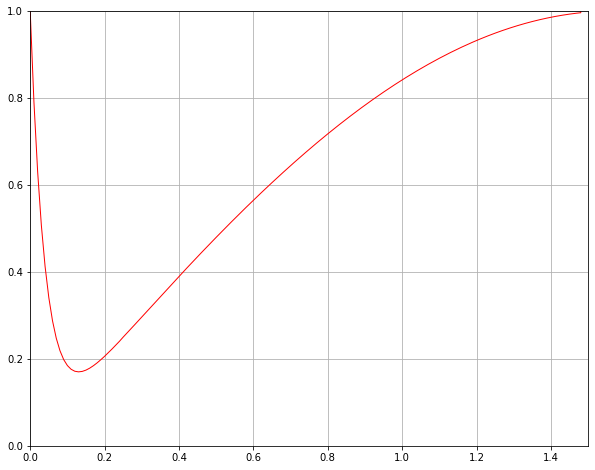

In [62]:
%%time

a = 0; b = 1.5

t_arr2, y_arr2 = RK_cauchy2(func, y0, a, b)
#t_arr2 = t_arr2[0:-1]
fig, ax = plt.subplots(figsize = [10, 8])
ax.plot(t_arr2, y_arr2, 'r-', lw=1)
plt.xlim([0, 1.5])
plt.ylim([0, 1])
#plt.legend(loc='best')
plt.grid(True)

Недостаток неявного метода Рунге-Кутты заключается в том, что на каждом шаге надо решать уравнение вида:

$$y_{n+1} = y_{n} + h\frac{f(x_{n}, y_{n}) + f(x_{n+1}, y_{n+1})}{2} $$

Естественным для решения этой задачи кажется использование метода простых итераций с формулой:

$$ y_{n+1} = y_{n} + h\frac{f(x_{n}, y_{n}) + f(x_{n+1}, \widetilde{y}_{n+1})}{2} $$ 

В этой формуле простая итерация системы уравнений идёт относительно $y_{n+1}$, записанной в форме сжимающего отображения. Согласно условию Липшица, на отображение накладывается ограничение для того, чтобы оно было сжимающим. Условием сходимости итерационного процесса будет являться неравенство:

$$ h |\frac{\partial{f}}{\partial{y}}| < 1 $$.

При условии $ |\frac{\partial{f}}{\partial{y}}| \leq L $ получаем ограничение на шаг $h < \frac{1}{L} $

Для жёстких задач константа $L$ обычно велика, и получаемое ограничение не слишком сильно отличается от ограничения, накладываемого на явную схему. 

К тому же, это требует дополнительных затрат производительности. Все неявные s-этапные методы требуют вычислений функций $f$ на шаге не меньше, чем 2s.

Можно воспользоваться методом Ньютона. Для этого запишем уравнение в виде:

$$ \phi(y_{n+1}) = y_{n+1} - y_{n} - h\frac{f(x_{n}, y_{n}) + f(x_{n+1}, y_{n+1})}{2} $$

Разложив $ \phi(y_{n+1})$ по формуле Тейлора в окрестности предыдущей итерации, получим уравнение:

$$ (\frac{\partial{\phi}}{\partial{y_{n+1}}})^{n}(y_{n+1} - y_{n}) = -\phi(y_{n}) $$

и по формуле для метода Ньютона: 

$$ y_{n+1} = y_{n} + (y_{n+1} - y_{n}) $$


Примерно измерим и сравним производительность методов по времени. 

Жёсткая система линейных ОДУ.

Явный метод Эйлера с шагом 0.001:


In [182]:
%%time

dt = 0.001

tt21, y21 = euler_sys_solve(A, u_in, T, dt)

Wall time: 125 ms


Неявный метод Рунге-Кутты с шагом 0.01 (даёт примерно такую же степень точности):

In [195]:
%%time

dt = 0.01
tt31, y31 = RK_impl_solve(A, u_in, T, dt)

Wall time: 43.1 ms


График для сравнения решений:

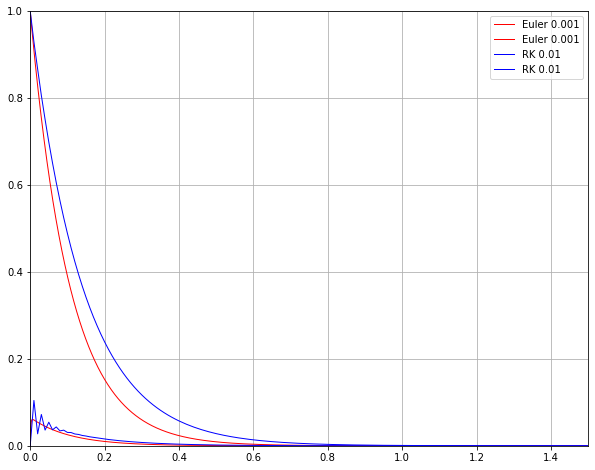

In [196]:
fig, ax = plt.subplots(figsize = [10, 8])
ax.plot(tt21, y21, 'r-', label = 'Euler 0.001', lw=1)
ax.plot(tt31, y31, 'b-', label = 'RK 0.01', lw=1)
plt.xlim([0, 1.5])
plt.ylim([0, 1])
plt.legend(loc='best')
plt.grid(True)

Жёсткая задача Коши для ОДУ 1-го порядка:

Неявный метод Эйлера c шагом 0.001:

In [199]:
def euler_cauchy_2(func, y0, h, a, b): #мб следует убрать Рунге-Ромберга
    num_steps = int((b-a)/h)
    tt = np.arange(a, b+h, h) #сам отрезок х
    y = np.empty(num_steps+1)
    y[0] = y0
    for k in range(num_steps):
        y[k+1] = y[k] + h*func(tt[k], y[k])

        
    return tt, y

In [200]:
%%time

h = 0.001
t_arr11, y_arr11 = euler_cauchy_2(func, y0, h, a, b)


Wall time: 16 ms


In [201]:
def RK_cauchy1(func, y0, h, a, b):
    num_steps = int((b-a)/h)
    tt = np.arange(a, b+h, h) #отрезок t от 0 до 0.25
    y = np.empty(num_steps+1)
    y[0] = y0
    for k in range(num_steps-1):
        #print(tt[k])
        ytemp = y[k] + h*func(tt[k], y[k])
        y[k+1] = y[k] + 0.5*h*(func(tt[k], y[k]) + func(tt[k+1], ytemp))   
    return tt, y

In [202]:
%%time 

h = 0.01
t_arr21, y_arr21 = RK_cauchy1(func, y0, h, a, b)


Wall time: 4.51 ms


Для жёсткой задачи Коши приведём также в сравнение явный метод Рунге-Кутты второго порядка точности (и протестируем с шагом 0.001)

In [203]:
def RK_cauchy_2step_expl(func, y0, h, a, b):
    num_steps = int((b-a)/h)
    tt = np.arange(a, b+h, h) #отрезок t от 0 до 0.25
    y = np.empty(num_steps+1)
    y[0] = y0
    for k in range(num_steps-1):
        #print(tt[k])
        ytemp = y[k] + 0.5*h*func(tt[k], y[k])
        y[k+1] = y[k] + h*func(tt[k] + 0.5*h, ytemp)
    return tt, y

In [204]:
%%time 

h = 0.001
t_arr31, y_arr31 = RK_cauchy_2step_expl(func, y0, h, a, b)

Wall time: 31.1 ms


График для сравнения решений:


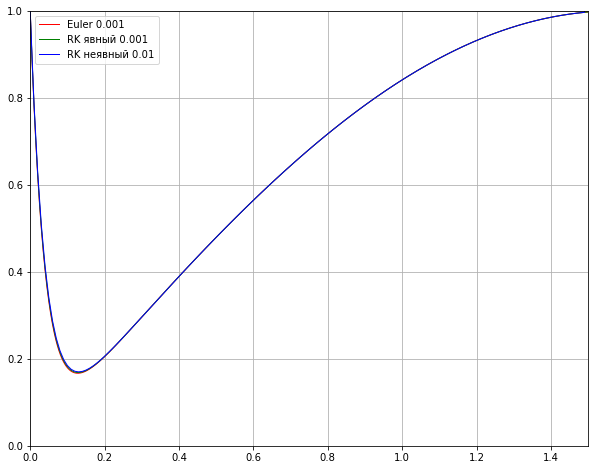

In [206]:
fig, ax = plt.subplots(figsize = [10, 8])
ax.plot(t_arr11, y_arr11, 'r-', label = 'Euler 0.001', lw=1)
ax.plot(t_arr31, y_arr31, 'g-', label = 'RK явный 0.001', lw=1)
ax.plot(t_arr21, y_arr21, 'b-', label = 'RK неявный 0.01', lw=1)
plt.xlim([0, 1.5])
plt.ylim([0, 1])
plt.legend(loc='best')
plt.grid(True)

Три графика практически идентичны и визуально неотличимы друг от друга.

Как видно, в общем неявные методы сильно выигрывают в производительности. Всё же, разница в шаге в 10 раз играет слишком высокую роль.